In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

#gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "/mnt/sframe/docs_prod_02/"
PATH_TO_JSON = "/mnt/sframe/docs_prod_05/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

### Read processed documents

In [2]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY', 100*1024*1024*1024) # 100GB
gl.set_runtime_config('GRAPHLAB_FILEIO_MAXIMUM_CACHE_CAPACITY_PER_FILE', 100*1024*1024*1024) # 100GB

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-17339 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1443427110.log
[INFO] GraphLab Server Version: 1.6.1


In [ ]:
def transf(x):
    return 50.0 * np.log1p(np.log1p(x))

In [3]:
def transf(x):
    return x

In [ ]:
gl.get_runtime_config()

In [4]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))
sf['num_words'] = sf['text'].apply(lambda xs: transf(len(xs)))

In [6]:
sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

In [7]:
sf2.shape

(403618, 26)

In [10]:
sf.column_names

<bound method SFrame.column_names of Columns:
	id	str
	shinn	dict
	text	str
	num_words	int

Rows: 403618

Data:
+---------+-------------------------------+-------------------------------+
|    id   |             shinn             |              text             |
+---------+-------------------------------+-------------------------------+
| 3355800 | {'shop': 0, 'parens': 1, '... | fuck photocopi appropri ti... |
| 3355801 | {'shop': 0, 'parens': 50, ... | imgr array showrandomimg t... |
| 3355812 | {'shop': 2, 'parens': 89, ... | barri leiner vinton cerf d... |
| 3355814 | {'shop': 0, 'parens': 0, '... |  happi birthday maimonid j... |
| 3355837 | {'shop': 0, 'parens': 0, '... | join convers between paul ... |
| 3355842 | {'shop': 0, 'parens': 0, '... |        carr edg chrome        |
| 3355846 | {'shop': 0, 'parens': 7, '... | year look forward kimberle... |
| 3355890 | {'shop': 0, 'parens': 0, '... | pleas enabl refresh page b... |
| 3355902 | {'shop': 0, 'parens': 5, '... | everi mo

In [11]:
sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

### Read train/test labels and merge into documents

In [12]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

In [18]:
features = [
            'a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt',
            'num_words'
           ]

In [19]:
# fill in empty
for f in features:
    train = train.fillna(f, 0.0)     
    test = test.fillna(f, 0.0)

In [20]:
features = features + ['shinn']
for f in features:
    train = train.fillna('shinn', {})     
    test = test.fillna('shinn', {})

### Generate BOW

In [21]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [22]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf5e5', min_document_frequency=5e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [ ]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=18, 
                                                                  output_column_name='tfidf_hashed_18'))
train['tfidf_hashed_18'] = hash_encoder.transform(train)['tfidf_hashed_18']
test['tfidf_hashed_18'] = hash_encoder.transform(test)['tfidf_hashed_18']

### Split training set for cross-validation

In [23]:
train_train, train_cv = train.random_split(0.80, seed=107)

In [24]:
TRAIN, CV = train_cv.random_split(0.50, seed=113)

# Generate Submission Model

Started at 02:12:00am

In [35]:
gl.classifier.random_forest_classifier.create?

In [38]:
model200=model

In [39]:
model = gl.classifier.random_forest_classifier.create(train, target='sponsored',
                                                      features=features + ['tfidf5e5'],
                                                      num_trees=80,
                                                      max_depth=150,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Random forest classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 320197
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 18
PROGRESS: Number of unpacked features : 121809
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.752e-01   7.689e-01       14.29s
PROGRESS:      1   9.773e-01   8.104e-01       23.76s
PROGRESS:      2   9.806e-01   8.158e-01       34.57s
PROGRESS:      3   9.831e-01   8.178e-01       45.36s
PROGRESS:      4   9.848e-01   8.177e-01       55.44s
PROGRESS:      5   9.861e-01   8.228e-01       65.78s
PROGRESS:      6   9.867e-01

In [ ]:
model = gl.classifier.boosted_trees_classifier.create(train, target='sponsored',
                                                      #features=features + ['tfidf_hashed_18'],
                                                      features=features + ['tfidf'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=None)

In [ ]:
lr_model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [40]:
import datetime
print(datetime.datetime.now())

2015-09-28 09:26:25.327088


In [41]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
#submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_shinn_rf_2.csv', index=False, float_format='%1.8f')

In [ ]:
model.save('/mnt/sframe/model_RF_100_100_040_100_bits18')

In [ ]:
test

# Experiment

### Split train into *train_train*/*train_cv*

In [ ]:
features

In [ ]:
train_train = train_train.dropna()
train_cv = train_cv.dropna()

In [ ]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=30,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [ ]:
FN.shape, FP.shape

In [ ]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [ ]:
FN[720:730]

In [ ]:
FP

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

In [ ]:
svm_model

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
train.head()

# Continue with data

In [ ]:
train = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_train')
test = gl.load_sframe('/mnt/sframe/counts_and_tfidf_hashed_18_test')

train_train = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_train')
train_cv = gl.load_sframe('/mnt/sframe/num_words_counts_and_tfidf_hashed_18_split_train_cv')

TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [25]:
train.save('/mnt/sframe/shinn_train')
test.save('/mnt/sframe/shinn_test')

train_train.save('/mnt/sframe/shinn_split_train_train')
train_cv.save('/mnt/sframe/shinn_split_train_cv')
#train_train = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_train')
#train_cv = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_cv')

In [ ]:
TRAIN.head()

## Try classifiers

In [30]:
model = gl.classifier.random_forest_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf5e5'],
                                                      num_trees=10,
                                                      max_depth=150,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

PROGRESS: Random forest classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 33596
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 18
PROGRESS: Number of unpacked features : 117341
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.715e-01   6.816e-01        1.45s
PROGRESS:      1   9.738e-01   7.137e-01        2.52s
PROGRESS:      2   9.792e-01   7.199e-01        3.69s
PROGRESS:      3   9.805e-01   7.276e-01        4.78s
PROGRESS:      4   9.825e-01   7.314e-01        5.83s
PROGRESS:      5   9.847e-01   7.336e-01        6.99s
PROGRESS:      6   9.857e-01   7.379e-01        8.05s
PROGRESS:      7   9.862e-01   7.387e-01        9.16s
PROGRESS:      8   9.876e-01   7.392e-01       10.21s
PROGRESS:      9   9.877e-01   7.464e-

AUC = 0.880273


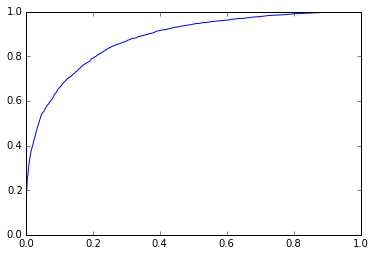

In [31]:
results = model.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=300,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.boosted_trees_classifier.get_default_options()

In [ ]:
TRAIN, CV = train_cv.random_split(0.50, seed=113)

In [ ]:
CV.shape

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(TRAIN, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=500,
                                                      column_subsample=0.3,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=CV)

In [ ]:
results = model_boosted.evaluate(CV, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.2,
                                                      max_iterations=400,
                                                      column_subsample=0.4,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [ ]:
train_cv_pred = gl.SFrame()
train_cv_pred['pred'] =model_boosted.predict(train_cv)
train_cv_pred['actual'] = train_cv['sponsored']
train_cv_pred['id'] = train_cv['id']

In [ ]:
pred_over = train_cv_pred[train_cv_pred['pred'] > train_cv_pred['actual']]
pred_under = train_cv_pred[train_cv_pred['pred'] < train_cv_pred['actual']]

In [ ]:
for z in list(pred_under.sample(0.02)['id'].apply(lambda x: 'aws s3 cp s3://sparkydotsdata/kaggle/native/orig/' + x + '_raw_html.txt ' + x +'raw_html')):
    print(z) 

In [ ]:
results = model_boosted.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
def custom_evaluator(model, train, test):
    results = model.evaluate(test, metric='roc_curve')
    a = results['roc_curve']

    fpr = list(a['fpr'])
    tpr = list(a['tpr'])
    fpr[0] = 1.0
    tpr[0] = 1.0
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
    return {'AUC': AUC}

In [ ]:
job0 = job

In [ ]:
params = dict([
        ('target', 'sponsored'),
        ('features', [features + ['tfidf_hashed_18']]),
        ('max_depth', [6]),
        ('step_size', [0.2]),
        ('max_iterations', [100, 150, 200]),
        ('column_subsample', [0.4]),
        ('validation_set', [None])
    ])

job = gl.grid_search.create((TRAIN, CV), 
                              gl.boosted_trees_classifier.create, 
                              params, 
                              evaluator=custom_evaluator)
job.get_results()

In [ ]:
models = job.get_models()

In [ ]:
results = job.get_results()

In [ ]:
results = results.to_dataframe()

In [ ]:
results.boxplot('AUC', by='max_iterations')

In [ ]:
results.sort('AUC', ascending=False)

In [ ]:
len(models)

In [ ]:
job.get_metrics()

In [ ]:
aa = scipy.stats.distributions.expon(.1)

In [42]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [43]:
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
#train = df_full[df_full.sponsored.notnull()].fillna(0)
#test = df_full[df_full.sponsored.isnull() & df_full.file.isin(test_files)].fillna(0)
# clf.fit(train.drop(['file', 'sponsored'], 1), train.sponsored)

# print('--- Create predictions and submission')
# submission = test[['file']].reset_index(drop=True)
# submission['sponsored'] = clf.predict_proba(test.drop(['file', 'sponsored'], 1))[:, 1]
# submission.to_csv('native_btb_basic_submission.csv', index=False)

In [61]:
shiTRAIN = shiTRAIN.to_dataframe()
shiCV = shiCV.to_dataframe()

In [60]:
for col in shiTRAIN.column_names:
    shiTRAIN[col] = 

<bound method SFrame.dtype of Columns:
	num_words	int
	a_href	int
	par	int
	title	int
	img	int
	btn	int
	input	int
	li	int
	link	int
	meta	int
	script_avg	float
	script_b_avg	float
	script_cnt	int
	script_b_cnt	int
	style_avg	float
	style_cnt	int
	shinn.braces	int
	shinn.brackets	int
	shinn.cheap	int
	shinn.col	int
	shinn.commas	int
	shinn.get	int
	shinn.length	int
	shinn.lines	int
	shinn.parens	int
	shinn.periods	int
	shinn.sale	int
	shinn.semi	int
	shinn.shop	int
	shinn.spaces	int
	shinn.tabs	int
	shinn.uppers	int
	shinn.words	int
	shinn.you	int

Rows: 33596

Data:
+-----------+--------+-----+-------+-----+-----+-------+-----+------+------+
| num_words | a_href | par | title | img | btn | input |  li | link | meta |
+-----------+--------+-----+-------+-----+-----+-------+-----+------+------+
|    7175   |  202   |  1  |   55  |  60 |  0  |   1   |  52 |  22  |  24  |
|    1856   |   87   |  14 |   74  |  27 |  2  |   2   | 102 |  8   |  22  |
|    281    |   38   |  0  |   38  |  32 

In [64]:
clf.fit(shiTRAIN, shiTRAIN_label)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [48]:
shiTRAIN = TRAIN.unpack('shinn')
shiCV = CV.unpack('shinn')

In [ ]:
shiTRAIN_label = np.asarray(shiTRAIN['sponsored'])
shiCV_label = np.asarray(shiCV['sponsored'])

In [63]:
shiTRAIN_label = np.asarray(shiTRAIN_label, float)
shiCV_label = np.asarray(shiCV_label, float)

In [57]:
shiTRAIN_tf = shiTRAIN['tfidf5e5']
shiCV_tf = shiCV['tfidf5e5']

In [58]:
shiTRAIN.remove_columns(['tfidf5e5'])
shiCV.remove_columns(['tfidf5e5'])
# shiTRAIN.remove_columns(['text', 'bow', 'sponsored', 'id'])
# shiCV.remove_columns(['text', 'bow', 'sponsored', 'id'])

num_words,a_href,par,title,img,btn,input,li,link,meta,script_avg,script_b_avg,script_cnt,script_b_cnt
6671,183,20,31,13,0,12,150,10,53,372.3,478.3,27,21
1010,118,2,59,96,3,6,115,15,30,507.5,1520.5,18,6
1948,33,9,41,9,2,10,15,16,5,289.3,420.4,32,22
1586,60,21,27,12,5,11,41,10,5,549.7,625.4,33,29
3816,458,129,7,142,0,14,192,24,22,680.0,1747.1,54,21
325,2,0,35,4,0,0,0,0,2,231.7,347.0,6,4
16876,310,22,44,82,2,19,95,14,26,503.8,1150.4,32,14
6965,136,42,51,35,7,19,117,12,17,826.5,956.9,22,19
7214,141,4,86,42,0,15,59,5,38,335.5,485.2,55,38
11992,114,58,44,23,1,12,57,4,18,377.8,409.3,26,24


In [49]:
shiTRAIN = shiTRAIN.to_dataframe drop('text', 1)
shiCV = shiCV.drop('text', 1)

AttributeError: 'SFrame' object has no attribute 'drop'

In [51]:
shiTRAIN.head()

sponsored,id,num_words,a_href,par,title,img,btn,input,li,link,meta,script_avg,script_b_avg
0,921145,7175,202,1,55,60,0,1,52,22,24,245.8,533.2
0,921362,1856,87,14,74,27,2,2,102,8,22,474.7,560.8
0,921468,281,38,0,38,32,0,0,0,4,11,100.1,199.3
0,921558,7424,98,13,62,21,0,0,45,14,4,218.7,654.0
0,92163,2835,38,20,53,30,0,0,19,4,16,270.3,431.8
0,921926,1490,72,14,38,23,1,17,58,4,15,299.1,373.6
0,922092,2999,62,49,61,30,0,24,23,17,3,235.4,587.1
0,922131,3729,80,29,110,16,0,10,24,16,16,155.8,358.3
0,922167,26458,189,114,25,74,0,6,131,26,23,340.6,777.1
0,922274,734,71,2,73,1,3,15,70,10,35,501.6,644.6
